# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [7]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [3]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf



Load the dataset.

In [4]:
# Load and unzip the dataset
import os
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Colab Notebooks/data"
#! unzip '/content/drive/My Drive/Colab Notebooks/data.zip'


Mounted at /content/drive
Cardboard  Food_Waste  Glass  Metal  Other  Paper  Plastic


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [5]:
import cv2

# Create a function to load the raw images
def load_image(img_path):
    # Load image using OpenCV (in BGR)
    img = cv2.imread(img_path)

    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# Create a function to load the raw images center-crop it to square, resize to target size, and normalize it.
#def load_and_crop_image(img_path, target_size=(150, 150)):
#    """
#    Load an image from disk, center-crop it to square, resize to target size, and normalize it.
#
#    Args:
#        img_path (str): Path to the image file.
#        target_size (tuple): Desired output size (width, height).
#
#    Returns:
#        np.ndarray: Preprocessed image array.
#    """
#    # Load image using OpenCV (in BGR)
#    img = cv2.imread(img_path)
#
#    if img is None:
#        raise ValueError(f"Image not found or unreadable: {img_path}")
#
#    # Convert to RGB
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#
#    # Get original dimensions
#    h, w, _ = img.shape
#    min_dim = min(h, w)
#
#    # Compute cropping box for center crop
#    start_x = (w - min_dim) // 2
#    start_y = (h - min_dim) // 2
#    cropped_img = img[start_y:start_y + min_dim, start_x:start_x + min_dim]
#
#    # Resize to target size
#    resized_img = cv2.resize(cropped_img, target_size)
#
#    # Normalize to [0, 1]
#    normalized_img = resized_img.astype(np.float32) / 255.0
#
#    return normalized_img


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [6]:
# Get the images and their labels
import glob
from tqdm import tqdm

# load all images and labels
def load_dataset(dataset_dir, target_size=(150, 150)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))  # Alphabetical class order
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        image_paths = glob.glob(os.path.join(class_path, '*'))
        for img_path in tqdm(image_paths, desc=f"Loading {class_name}"):
            img = load_image(img_path)
            if img is not None:
                images.append(img)
                labels.append(class_to_idx[class_name])

    return np.array(images), np.array(labels), class_names


In [7]:
DATASET_DIR = '/content/drive/My Drive/Colab Notebooks/data'
OUTPUT_RESIZED_DATASET_DIR='/content/drive/My Drive/Colab Notebooks/Resized_Data'
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
import matplotlib.pyplot as plt

#images, labels, class_names = load_dataset(DATASET_DIR, IMAGE_SIZE)
images, labels, class_names = load_dataset(DATASET_DIR, IMAGE_SIZE)

print(f"Total images loaded: {len(images)}")
print(f"Class names: {class_names}")
print(f"Labels shape: {labels.shape}, Images shape: {images.shape}")



Loading Plastic: 100%|██████████| 1420/1420 [00:35<00:00, 40.04it/s] 


Total images loaded: 6760
Class names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Labels shape: (6760,), Images shape: (6760, 256, 256, 3)


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [8]:
# Visualise Data Distribution

import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(labels, class_names):
    # Count labels
    class_counts = Counter(labels)

    # Create lists in correct label order
    label_ids = list(range(len(class_names)))
    counts = [class_counts[i] for i in label_ids]

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, counts, color='skyblue', edgecolor='black')

    # Annotate bars with counts
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontsize=10)

    plt.xlabel("Waste Categories", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title("Class Distribution in Waste Dataset", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


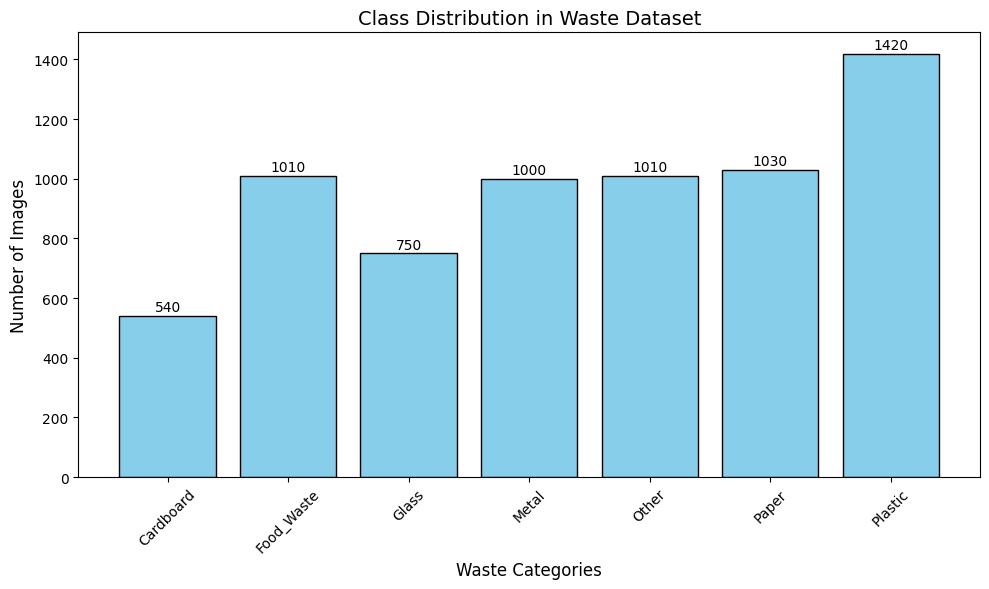

In [14]:
plot_class_distribution(labels, class_names)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [9]:
# Visualise Sample Images (across different labels)

# Visual Verification (Plot Sample Images)
def show_samples(images, labels, class_names, n=8):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()


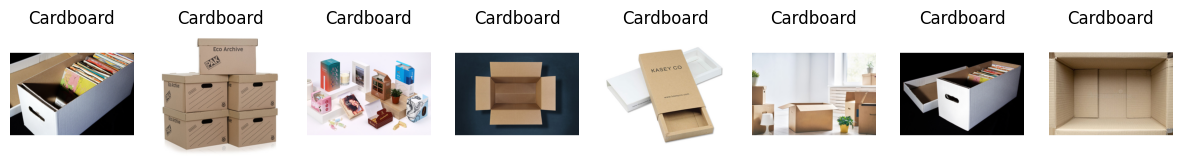

In [10]:
show_samples(images, labels, class_names)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [11]:
# Find the smallest and largest image dimensions from the data set
# To find the smallest and largest image dimensions (height × width) in your dataset,
# scan all images directly from disk (not the resized ones), and check their original shape using OpenCV.
import cv2
import os
import glob

def get_image_dimensions_stats(dataset_dir):
    min_width = float('inf')
    min_height = float('inf')
    max_width = 0
    max_height = 0
    dim_examples = {
        "min": None,
        "max": None
    }

    class_names = sorted(os.listdir(dataset_dir))

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        image_paths = glob.glob(os.path.join(class_path, '*'))
        for img_path in image_paths:
            img = cv2.imread(img_path)
            if img is None:
                continue
            h, w = img.shape[:2]

            if h < min_height or w < min_width:
                min_height = min(min_height, h)
                min_width = min(min_width, w)
                dim_examples["min"] = img_path

            if h > max_height or w > max_width:
                max_height = max(max_height, h)
                max_width = max(max_width, w)
                dim_examples["max"] = img_path

    return (min_width, min_height), (max_width, max_height), dim_examples


In [12]:
min_dim, max_dim, examples = get_image_dimensions_stats(DATASET_DIR)

print(f" Smallest image dimensions: {min_dim[0]}x{min_dim[1]} px")
print(f" Path: {examples['min']}")

print(f" Largest image dimensions: {max_dim[0]}x{max_dim[1]} px")
print(f" Path: {examples['max']}")

 Smallest image dimensions: 256x256 px
 Path: /content/drive/My Drive/Colab Notebooks/data/Cardboard/file_49.png
 Largest image dimensions: 256x256 px
 Path: /content/drive/My Drive/Colab Notebooks/data/Cardboard/file_49.png


In [13]:
# Resize the image dimensions
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Create a function to load the raw images center-crop it to square, resize to target size, and normalize it.
def load_and_crop_image(img_path, target_size=(150, 150)):
    """
    Load an image from disk, center-crop it to square, resize to target size, and normalize it.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired output size (width, height).

    Returns:
        np.ndarray: Preprocessed image array.
    """
    # Load image using OpenCV (in BGR)
    img = cv2.imread(img_path)

    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get original dimensions
    h, w, _ = img.shape
    min_dim = min(h, w)

    # Compute cropping box for center crop
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    cropped_img = img[start_y:start_y + min_dim, start_x:start_x + min_dim]

    # Resize to target size
    resized_img = cv2.resize(cropped_img, target_size)

    # Normalize to [0, 1]
    normalized_img = resized_img.astype(np.float32) / 255.0

    return normalized_img


# load all images and labels
def resize_images(dataset_dir, output_dir, target_size=(150, 150)):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))  # Alphabetical class order
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        os.makedirs(output_class_path, exist_ok=True)
        image_paths = glob.glob(os.path.join(class_path, '*'))
        for img_path in tqdm(image_paths, desc=f"Loading {class_name}"):
            img = load_and_crop_image(img_path)
            if img is not None:
                images.append(img)
                labels.append(class_to_idx[class_name])

                # Construct output path
                filename = os.path.basename(img_path)
                save_path = os.path.join(output_class_path, filename)

                # Save the resized image
                cv2.imwrite(save_path, img)

    return np.array(images), np.array(labels), class_names



In [14]:
resize_images(DATASET_DIR, OUTPUT_RESIZED_DATASET_DIR, target_size=(150, 150))
print("✅ All images resized and saved.")

Loading Plastic: 100%|██████████| 1420/1420 [09:37<00:00,  2.46it/s]


✅ All images resized and saved.


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [15]:
# Encode the labels suitably
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

tf.debugging.set_log_device_placement(True)

# Assuming `labels` is a NumPy array of integers
num_classes = len(class_names)
labels_one_hot = to_categorical(labels, num_classes)

print(labels[0])         # e.g. 2
print(labels_one_hot[0]) # e.g. [0. 0. 1. 0. 0. 0. 0.]


0
[1. 0. 0. 0. 0. 0. 0.]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [21]:
# Assign specified parts of the dataset to train and validation sets
import os
import glob
import shutil

def split_dataset_by_portion(resized_dir, output_base_dir, train_ratio=0.8):
    class_names = sorted(os.listdir(resized_dir))

    for class_name in class_names:
        class_path = os.path.join(resized_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Get all image paths and sort them to ensure consistent ordering
        image_paths = sorted(glob.glob(os.path.join(class_path, '*')))
        total = len(image_paths)
        split_index = int(total * train_ratio)

        train_paths = image_paths[:split_index]
        val_paths = image_paths[split_index:]

        # Create class subdirectories for train and val
        for split, paths in [('train', train_paths), ('val', val_paths)]:
            split_class_dir = os.path.join(output_base_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img_path in paths:
                filename = os.path.basename(img_path)
                target_path = os.path.join(split_class_dir, filename)
                shutil.copy2(img_path, target_path)


In [22]:
resized_dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Resized_Data'
output_split_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset_split'

split_dataset_by_portion(resized_dataset_dir, output_split_dir, train_ratio=0.8)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [23]:
# Build and compile the model

import tensorflow as tf
from tensorflow.keras import layers, models

def build_waste_classifier(input_shape=(150, 150, 3), num_classes=7):
    model = models.Sequential()

    # 🔹 Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # 🔹 Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # 🔹 Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # 🔹 Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # 🔹 Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [24]:
# compile the model

model = build_waste_classifier()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # use categorical_crossentropy if labels are one-hot
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:loc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,714,055 (40.87 MB)

 Trainable params: 10,713,095 (40.87 MB)

 Non-trainable params: 960 (3.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [25]:
# Training
# Folder structure /content/drive/MyDrive/Colab Notebooks/Dataset_split/
#├── train/
#├── val/

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Dataset using ImageDataGenerator
train_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset_split/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset_split/val'

# Data generators with normalization and augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32
img_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'  # use 'categorical' if one-hot encoded
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)



Found 5408 images belonging to 7 classes.
Found 1352 images belonging to 7 classes.


In [ ]:
# Train the Model
# Optional callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy',
                             save_best_only=True, verbose=1)

# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/3
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [ ]:
# OPtional visualize Training Output for accuracy/loss using:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model Loss")
plt.show()

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics
# Load Test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset_split/test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # important for correct label ordering
)


In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Get predication
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results